In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sqlite3
import gc
import os

%matplotlib inline

# A) Descriptive analysis

If the wget command below does not work for any reason. The data can be manually downloaded in zip format from: http://www.ssa.gov/oact/babynames/state/namesbystate.zip

Once downloaded, just copy it to your repository directory, and the code below.

In [2]:
!wget --no-check-certificate http://www.ssa.gov/oact/babynames/state/namesbystate.zip

URL transformed to HTTPS due to an HSTS policy
--2018-11-04 22:36:21--  https://www.ssa.gov/oact/babynames/state/namesbystate.zip
Resolving www.ssa.gov... 137.200.39.19, 2001:1930:d07::aaaa
Connecting to www.ssa.gov|137.200.39.19|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 21574769 (21M) [application/zip]
Saving to: ‘namesbystate.zip.1’

namesbystate.zip.1  100%[===================>]  20.58M  2.81MB/s    in 7.3s    

2018-11-04 22:36:29 (2.81 MB/s) - ‘namesbystate.zip.1’ saved [21574769/21574769]



This will unzip the zip file into a folder with the same name

In [3]:
!unzip -oqd namesbystate namesbystate.zip

Creating a namesbystate sqlite3 database. I intend to store all the files as a single table within the database.

In [47]:
dbname = "namesbystate.db"
if not os.path.isfile(dbname): 
    connex = sqlite3.connect(dbname)  # Opens file if exists, else creates file
    cur = connex.cursor()  # This object lets us actually send messages to our DB and receive results
    files = glob.glob("namesbystate/*TXT") # Generating a list of files within the namesbystate folder
    
    for f in files:
        # Reading each state file in to a temperory dataframe and appending it to the sqlite3 DB created above
        df_tmp = pd.read_csv(f,header=None, names=['State','Gender','Year','Name','Count']) 
        df_tmp.to_sql(name="data", con=connex, if_exists="append", index=False)
        del df_tmp 
    gc.collect() # freeing up the memory used by the dataframes
else:
    connex = sqlite3.connect(dbname)  
    cur = connex.cursor()  

### 1. Please describe the format of the data files. Can you identify any limitations or distortions of the data?


The zip file contains 51 text files for each of the states and District of Columbia, and README file describing the contents of the zip file. Each text file contains comma separated values, in the same format i.e. 2-digit state code, sex (M = male or F = female), 4-digit year of birth (starting with 1910), the 2-15 character name, and the number of occurrences of the name. 

To ensure the privacy, they exclude names with fewer than 5 occurences in a year. This generates a bias whereby individuals with unique names will be excluded from any statistical estimates based on this data.

### 2. What is the most popular name of all time? (Of either gender)

The dataset includes Names and their occurences by year. To estimate the most popular name of all time, I am running a SQL query to return the names and the sum of the occurences where I group all the names, ignoring the other information i.e. State, Gender, etc.

In [48]:
query = """
SELECT Name, SUM(Count) AS sum_count
FROM data
GROUP BY Name
ORDER BY SUM(Count) DESC;
"""
df = pd.read_sql_query(query, con=connex)
df.head()

,Name,sum_count
0,James,5001762
1,John,4875934
2,Robert,4743843
3,Michael,4354622
4,William,3886371


It appears that the most popular name in the United States from 1910 - 2017 is James. As a side note, Mary at #6 is the most popular Female name, and the only Female name in the top 10 most popular name.

In [49]:
del df

### 3. What is the most gender ambiguous name in 2013? 1945?

To compute the gender ambiguity of the names, I am using the following logic:
- I break the names database into two datasets (imported into Pandas), by year of interest and gender. 
- I do an join of the two DataFrames, where the names in both genders are the same.
- I groupby the names and take the sum of occurrences, to generate two columns with the sum total of each name by gender.
- I estimate gender neutrality by calculating the ratio of number of women with a name to the total number of individuals with a name and how far that is from 0.5. 
- Finally, I only include those names that have at least 50 occurrences in both male and female bins to weed out small numbers.

In [50]:
# Computing the most gender neutral name in 2013 - 
df_m = pd.read_sql_query("SELECT Name, Count FROM data WHERE Year=? AND Gender=?", con=connex, params=(2013,'M'))
df_f = pd.read_sql_query("SELECT Name, Count FROM data WHERE Year=? AND Gender=?", con=connex, params=(2013,'F'))

In [51]:
df_mf = df_m.set_index("Name").join(df_f.set_index("Name"), lsuffix='_m', rsuffix='_f').groupby("Name").sum()
df_mf["% dissimilar"] = abs(50 - 100*(df_mf["Count_f"]/(df_mf["Count_m"]+df_mf["Count_f"])))
df_mf[(df_mf["Count_m"] > 50) & (df_mf["Count_f"] > 50)].sort_values(by='% dissimilar').head(1)

,Count_m,Count_f,% dissimilar
Name,,,
Devyn,1900,1908.0,0.105042


In 2013, the most gender ambiguous name is Devyn. Note there are 5 names that are more ambiguous, however since I placed a cut at having at least 50 counts of the name, these names were not displayed. The ignored names are: Lake, Legacy, Dakotah, Arlin, and Sonam.

In [52]:
# Computing the most gender neutral name in 1945 - 
df_m = pd.read_sql_query("SELECT Name, Count FROM data WHERE Year=? AND Gender=?", con=connex, params=(1945,'M'))
df_f = pd.read_sql_query("SELECT Name, Count FROM data WHERE Year=? AND Gender=?", con=connex, params=(1945,'F'))

In [53]:
df_mf = df_m.set_index("Name").join(df_f.set_index("Name"), lsuffix='_m', rsuffix='_f').groupby("Name").sum()
df_mf["% dissimilar"] = abs(50 - 100*(df_mf["Count_f"]/(df_mf["Count_m"]+df_mf["Count_f"])))
df_mf[(df_mf["Count_m"] > 50) & (df_mf["Count_f"] > 50)].sort_values(by='% dissimilar').head(1)

,Count_m,Count_f,% dissimilar
Name,,,
Kim,588,588.0,0.0


In 1945, the most gender ambiguous name is Kim. However, the name "Frankie" is a close second and with 12627 and 12532 counts of occurrences for the name, meant that it was a much more popular choice of name for both Men and Women at the time compared to Kim. 

In [54]:
del df_m, df_f, df_mf

### 4. Of the names represented in the data, find the name that has had the largest percentage increase in popularity since 1980. What was the largest percentage decrease since 1980?

My interpretation of this question is to find the name that changed the most in popularity (pos/neg) between the year 1980 and 2017. However, by doing so, I am explicitly ignoring any names that might have seen large swings in popularity in the intermediate 37 years.

In [55]:
query = """
SELECT Name, Year, Count
FROM data
WHERE Year >= ?
"""
df = pd.read_sql_query(query, con=connex, params=(1980,))

To calculate the percent change, I am grouping the names, and using the difference of the last vs first entry for each name to estimate the fraction. 

In [56]:
df_perc_change = df.set_index("Year")\
                      .groupby("Name")\
                      .apply(lambda x: 100*(x.Count.iloc[-1] - x.Count.iloc[0])/x.Count.iloc[0])\
                      .sort_values(ascending=False)
df_perc_change.head(5)

Name
Unknown     2860.0
Shimon      2480.0
Gitty       2200.0
Malka       1950.0
Yitzchok    1920.0
dtype: float64

According to the SSA database, they do not modify entries. So entries such as "Unknown" or "Baby" are kept as is. The 2860% rise in "Unknown" is interesting, but since it does not represent a single name, I am using "Shimon" which is the next name in the list to represent the name that has risen in popularity the most. Plotting the rise of babies with the name Shimon since 1980.

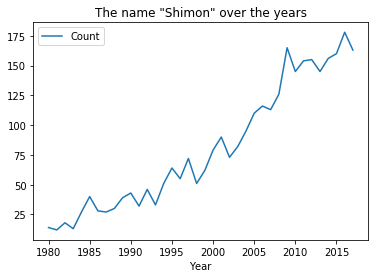

In [57]:
df[df["Name"]=="Shimon"].groupby("Year").sum().plot(title='The name "Shimon" over the years');

In [58]:
df_perc_change.tail(5)

Name
Sarah         -93.902439
Jessica       -93.965517
Latasha       -94.680851
Jennifer      -94.736842
Christopher   -95.081967
dtype: float64

Interesting four of the five names that have dropped the most in popularity since the start of the 80s are female names. However, the name that corresponded to the largest drop in popularity is Christopher.

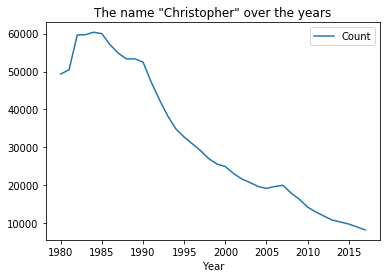

In [59]:
df[df["Name"]=="Christopher"].groupby("Year").sum().plot(title='The name "Christopher" over the years');

To find names that showed larger percentage variations during the span from 1980 - 2017, we would replace the first vs last with the lowest vs highest count of each name.

In [60]:
del df, df_perc_change

### 5. Can you identify names that may have had an even larger increase or decrease in popularity before 1980?

Similar to the previous question, I estimate the increase or decrease in popularity by looking for names that have shown the greatest change between 1910 and 1979.

In [61]:
df = pd.read_sql_query("SELECT Name, Year, Count FROM data", con=connex)
df_perc_change = df[df["Year"]<1980].set_index("Year")\
                      .groupby("Name")\
                      .apply(lambda x: 100*(x.Count.iloc[-1] - x.Count.iloc[0])/x.Count.iloc[0])\
                      .sort_values(ascending=False)
df_perc_change.head(5)

Name
Jennifer    2640.000000
Michael     2483.333333
Jason       2420.000000
Joshua      2320.000000
Mayra       2233.333333
dtype: float64

Based on this analysis, it appears that no name showed a larger increase in popularity from 1910-1980. 

Pre-1980, the name that showed the most consistent rise in popularity is Jennifer. Interestingly enough, in our analysis in the previous question we noticed that Jennifer was the name that had the second poorest trend since 1980. The rise and fall of the name Jennifer is captured in the next plot.

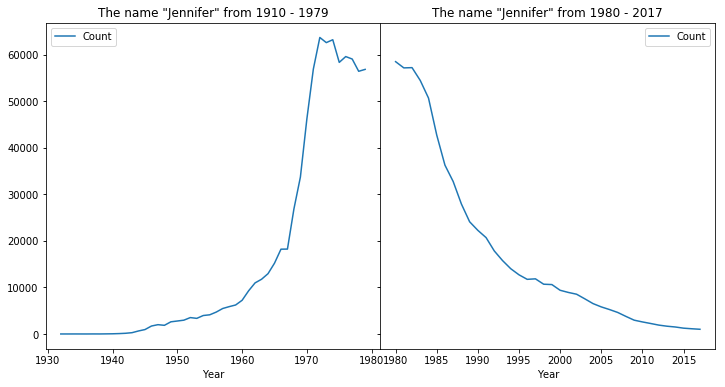

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0)
df[(df["Name"]=="Jennifer") & (df["Year"]<1980)].groupby("Year").sum().plot(ax=ax1, title='The name "Jennifer" from 1910 - 1979')
df[(df["Name"]=="Jennifer") & (df["Year"]>=1980)].groupby("Year").sum().plot(ax=ax2, title='The name "Jennifer" from 1980 - 2017');

In [63]:
df_perc_change.tail(5)

Name
Myrtle   -95.192308
Pearl    -95.238095
Rosa     -95.575221
Hattie   -96.062992
Lillie   -97.326203
dtype: float64

Lillie is the name that showed the most consistent fall in popularity. This drop in popularity is in fact greater than the drop in popularity of Christopher in the previous analysis.

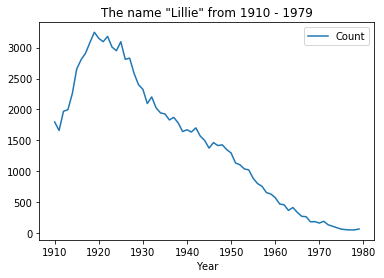

In [64]:
df[(df["Name"]=="Lillie") & (df["Year"]<1980)].groupby("Year").sum().plot(title='The name "Lillie" from 1910 - 1979');

There are two important points to consider from the figure above,
- while the name Lillie showed a larger decrease in popularity compared to Christopher. In absolute terms, even at its most popular, the name Lillie only went to ~3000 babies per year. While the name Christopher is at its lowest currently, but there are still ~10000 babies with that name born in 2017. 
- it is also interesting to note is that the name Lillie was actually on a rising trend till 1920 before it dropped. So it's actually percentage decrease is better captured by the difference of the max and min counts, rather than the first and last. 

To examine whether there are names that have had large changes in popularity, I examined the ratio of the difference of the max - min by the min count and present the results below. I have limited the results to names that have turned up at least 30 times over the years.

In [65]:
df_perc_change_minmax = df[df["Year"]<1980].set_index("Year")\
                      .groupby("Name")\
                      .apply(lambda x: 100*(x.Count.max() - x.Count.min())/x.Count.min() if len(x.Count) > 30 else np.nan)\
                      .dropna()\
                      .sort_values(ascending=False)
df_perc_change_minmax.head()

Name
Robert     200300.0
John       192600.0
Michael    184820.0
Mary       163580.0
David      162220.0
dtype: float64

Unsurprisingly, there are the names that have shown significantly larger variation over the years. The name Robert has seen a whopping 200300% change in popularity from 1910 to 1980. And as can be seen in the plot below, its popularity peaked in early 1940s and has declined ever since.

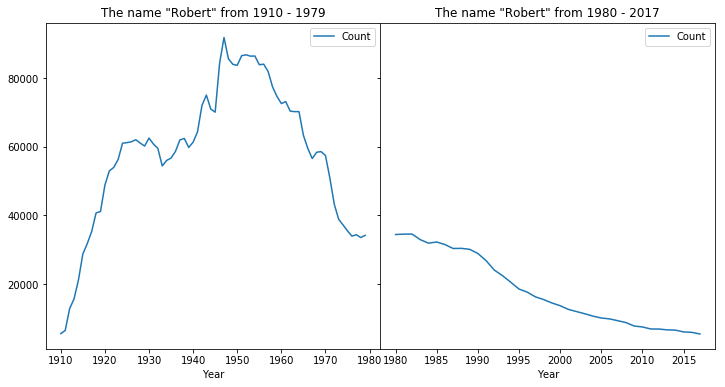

In [66]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0)
df[(df["Name"]=="Robert") & (df["Year"]<1980)].groupby("Year").sum().plot(ax=ax1, title='The name "Robert" from 1910 - 1979')
df[(df["Name"]=="Robert") & (df["Year"]>=1980)].groupby("Year").sum().plot(ax=ax2, title='The name "Robert" from 1980 - 2017');

Another surprising inclusion in the list of largest change is the name "Mary". Note that Mary is the most popular female name in the US over the past 117 years. However, when one plots the trend line for the name it is interesting to note how the popularity has varied over the last 12 decades.

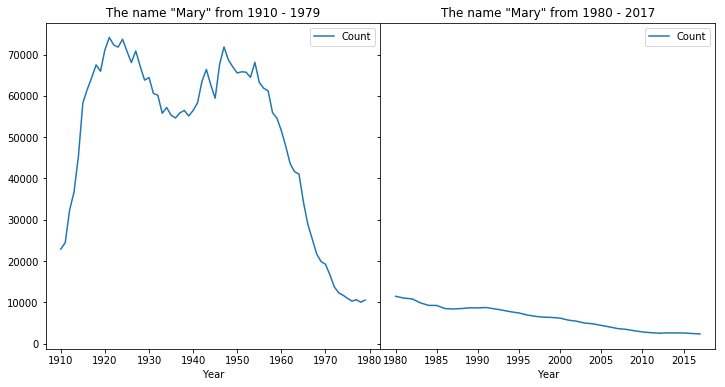

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0)
df[(df["Name"]=="Mary") & (df["Year"]<1980)].groupby("Year").sum().plot(ax=ax1, title='The name "Mary" from 1910 - 1979')
df[(df["Name"]=="Mary") & (df["Year"]>=1980)].groupby("Year").sum().plot(ax=ax2, title='The name "Mary" from 1980 - 2017');

As one can see, Mary might be the most popular name by total numbers. However, the name has seen a dramatic drop in popularity since approximately the 70s and is far from being a popular name for babies today.

In [68]:
del df, df_perc_change, df_perc_change_minmax
gc.collect();

# B) Onwards to insight

## Missing names

Right at the onset of the analysis it was noted that for protection of the privacy of individuals, names that occurred fewer than 5 times in a state would be excluded. 

I noted that this would result in a bias whereby the names of babies born would not reflect the actual numbers of babies in each state. This problem is further exacerbated by the fact that the dataset used is by state (rather than national), purely due to small numbers excluding the unique names.

To investigate how much of a bias this might be resulting in, I pulled up national birth and birth rate data from two sources:
- The first is Infoplease (https://www.infoplease.com/), who describe themselves as an online encyclopedia. The website contains birth and birth rate information from 1910 to 2005. Between 1910 and 1950, the data points are once every 5 years, and from 1950 onwards they are annual. The data are sourced from the United States Department of Health and Human Services.
- The second data source is the WONDER Online Database (http://wonder.cdc.gov/natality-current.html ), administered by the United States Department of Health and Human Services (US DHHS), and Centers for Disease Control and Prevention Center for Disease Control. This dataset covers births in the US between 1995 and 2017. 

In [69]:
# Extracting data from the SSA database
df = pd.read_sql_query("SELECT Name, Year, Count FROM data", con=connex)

To gather the data from the Infoplease website, we will use the Python requests library in combination with the BautifulSoup library. The parsed table, is converted to a Pandas DataFrame. 

In [70]:
import requests
from bs4 import BeautifulSoup

In [71]:
url = "https://www.infoplease.com/us/births/live-births-and-birth-rates-year"
r = requests.get(url)
soup = BeautifulSoup(r.text, "lxml")

In [72]:
table = soup.table
rows = []
for tr in table:
    if tr.sup:
        tr.sup.decompose()
    td = tr.find_all('td')
    rows.append([i.text for i in td])
df_infopls = pd.DataFrame(rows[1:], columns=["Year","Births","Birth Rate"])

In [73]:
df_infopls["Year"] = df_infopls["Year"].astype("int")
df_infopls["Births"] = df_infopls["Births"].str.replace(",","").astype("int")
df_infopls["Birth Rate"] = df_infopls["Birth Rate"].astype("float")

Including data taken from the CDC WONDER (Wide-ranging OnLine Data for Epidemiologic Research) data.

The download this data, I went to the following website: https://wonder.cdc.gov/natality.html
- where one can download the data from 1995 to 2017 from three separate web forms.
- I was unable to find an API that would allow me to download the data. So I manually, downloaded data and reformatted it into a CSV file: NationalBirths.csv. 
    - the CSV file has the information from all three web forms in a single page.
    - unfortunately, due to the manual formatting, expanding the analysis to include State information or other relevant pieces of information that are present through WONDER is quite tedious. Future work should either find a way to request data directly, or write a parser to read in the file format of WONDER database exported data. 

In [74]:
cdc_df_1995_2017 = pd.read_csv("NationalBirths.csv", index_col="Year", skipfooter=8, engine="python")
cdc_df_1995_2017["Total"] = cdc_df_1995_2017['M_Births'] + cdc_df_1995_2017['F_Births']

In [75]:
df_all3 = df.groupby("Year").sum()
df_all3 = df_all3.join(df_infopls.set_index("Year")).join(cdc_df_1995_2017)

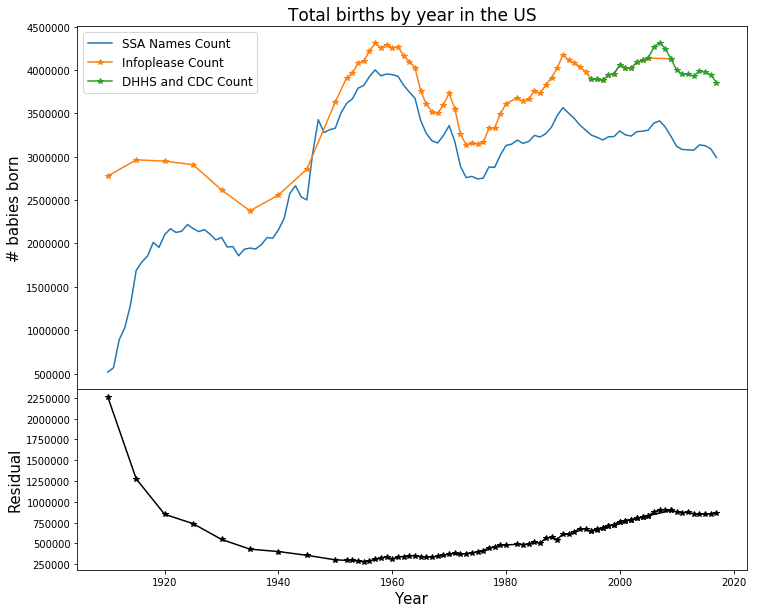

In [76]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10), sharex=True, gridspec_kw={'height_ratios':[2, 1]})
fig.subplots_adjust(hspace=0)
df_all3.plot(y="Count", ax=ax1, label='SSA Names Count')
df_all3["Births"].dropna().plot(ax=ax1, marker="*", label='Infoplease Count')
df_all3["Total"].dropna().plot(ax=ax1, marker="*", label='DHHS and CDC Count')
ax1.set_ylabel("# babies born", fontsize=15)
ax1.legend(fontsize=12)
(df_all3["Births"] - df_all3["Count"]).dropna().plot(ax=ax2, marker="*", color='k')
(df_all3["Total"] - df_all3["Count"]).dropna().plot(ax=ax2, marker="*", color='k')
ax2.set_ylabel("Residual", fontsize=15)
ax2.set_xlabel("Year", fontsize=15)
ax1.set_title("Total births by year in the US", fontsize=17);

Plotted in the top panel of the figure above is the total number of births in the US as recorded by the SSA names database (in blue), and the DHHS (in orange and green). The bottom panel in
- The values pre-1959 for the SSA vs DHHS plot are quite discrepant, and I believe this is because the DHHS adjusted the birth numbers for unregistered births, which I am assuming are deliveries done at home or from unregistered immigrants, these births and thus their names would be absent in the SSA names database. 
- If we assume that the two databases are fairly in synch post 1960, then the national trend over the past 50 years is that Americans are increasingly choosing more unique names for their children. 
- This trend appears to be stabilizing over the past ~10 years.

Next we expand this analysis to examine whether this trend holds for both genders. 

In [77]:
df = pd.read_sql_query("SELECT Name, Gender, Year, Count FROM data WHERE Year >= ?", con=connex, params=(1995,))

In [78]:
df_group = df.groupby(["Year","Gender"]).sum().unstack()

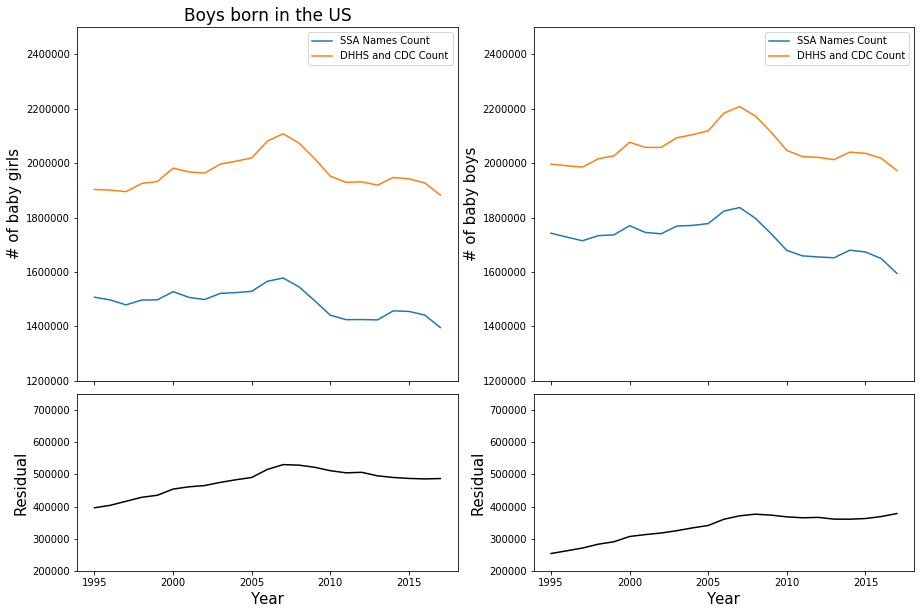

In [79]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10), sharex=True, gridspec_kw={'height_ratios':[4, 2]})
fig.subplots_adjust(hspace=0.05)

df_group["Count","F"].plot(ax=ax1, label='SSA Names Count'); cdc_df_1995_2017["F_Births"].plot(ax=ax1, label='DHHS and CDC Count')
df_group["Count","M"].plot(ax=ax2, label='SSA Names Count'); cdc_df_1995_2017["M_Births"].plot(ax=ax2, label='DHHS and CDC Count')
ax1.set_ylim(1.2E6,2.5E6); ax2.set_ylim(1.2E6,2.5E6)
ax1.legend(); ax2.legend()
ax1.set_ylabel("# of baby girls", fontsize=15); ax2.set_ylabel("# of baby boys", fontsize=15)
ax1.set_title("Girls born in the US", fontsize=17); ax1.set_title("Boys born in the US", fontsize=17)

(cdc_df_1995_2017["F_Births"] - df_group["Count","F"]).plot(ax=ax3, color='k')
(cdc_df_1995_2017["M_Births"] - df_group["Count","M"]).plot(ax=ax4, color='k')
ax3.set_ylim(2E5,7.5E5); ax4.set_ylim(2E5,7.5E5);
ax3.set_ylabel("Residual", fontsize=15); ax4.set_ylabel("Residual", fontsize=15)
ax3.set_xlabel("Year", fontsize=15); ax4.set_xlabel("Year", fontsize=15);

Plotted above are the birth statistics for girls (left) and boys (right), comparing the actual number of births (orange line) and the registered names with greater than 5 occurrences (blue line). The residuals panel shows the rate of change of the unique names as a function of time. 

- Both genders show a similar rising trend, that is a rising discrepancy between actual births and names, till ~2006-2008, after which it has stabilized over the past decade. 
- According to both, the SSA names database and the WONDER database, there are more boys born then girls per year, over the entire duration.
- However, the discrepancy between the names and births for the girls is a lot larger than that seen for boys, 1.42x greater to be precise. 

Taking this thought exercise a little further. If the discrepancy is attributed purely to the fact that at any name with fewer than 5 occurrences in a state would be kept out of the list.  
- Then this would suggest that in 2017 there were 486994 female names and 378149 male names excluded. 
- Or ~17000 names across the 51 regions (50 states + DC). These could be unique names or ones that total to fewer than 4 occurrences per state.
- Furthermore, when we compare this to actual births by gender from WONDER (1882615 girls and 1972885 boy in 2017), the discrepancy represents ~25% girl names and 20% boys names missing. 

I originally speculated that there might be a potential discrepancy between the actual births and the names in SSA database. Clearly, I have shown that there is a discrepancy. However, missing nearly a million baby names due to uniqueness of name, while plausible seems improbable. 

To look for possible explanation for the discrepancy, let us consider the source for each of the datasets. 
- The SSA dataset lists the names of babies from Social Security Card Applications (https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-data-by-state-and-district-of-). 
- The WONDER dataset has counts and rates of births occurring within the United States to U.S. residents and non-residents. (https://wonder.cdc.gov/wonder/help/Natality.html)

Not including names with occurrences less than 5 is definitely a large contributor. If there is a second reason for missing baby names: 
- then it could be if the rate of parents filing SSA for their children has been dropping with time.
- Or, it could be related to the sharp rise of immigrants in the US from Asia where systems like Social Security are not as common and thus not immediately perceived as useful. 
- Or, another possible explanation is if there has been a significant increase in undocumented immigrants over the past 20 years (compared to the period from 1960-1980), whose children are not being registered through the SSA for fear of deportation. https://en.wikipedia.org/wiki/Immigration_to_the_United_States#Demographics

Whatever the reason may be, this discrepancy significantly biases the SSA names dataset. 

I originally considered the problem of using the names dataset to try and track the rise of immigrant populations. As immigrant populations grow in areas, the popular names from their countries of origin should also rise in popularity in the US. It was while thinking of this problem, that I started wondering how accurate the names dataset might be?

A possible method of understanding the cause of this discrepancy, would be to look for sources of documented and undocumented immigrants over the last 23 years to see if the numbers track the general trend seen above.

In [80]:
del df, df_all3, df_group, df_infopls

## Name variants:

I realized that the SSA dataset keeps different spellings of the same name as distinct, see point 3 here: https://www.ssa.gov/oact/babynames/background.html. So the following names - Caitlin, Caitlyn, Kaitlin, Kaitlyn, Kaitlynn, Katelyn, and Katelynn would not be considered as variants of the same name and thus ranked separately. Spelling mistakes in the names or genders are a separate but further confounding issue. 

Depending on your requirement, considering these names as arising from a common root may or may not be a significant concern. It could potentially be considered as distorting the analyses like the most popular, or least popular names that was carried out above. 

I was considering how I would resolve this concern, if I wanted to try and combine all the names with similar roots. This could be quite valuable in cases of name matching, or to correct spelling errors. 

There is a python package called Fuzzywuzzy, which calculated the Levenshtein distance to attempt string matching and I show a few examples of how this would work.

In [81]:
from fuzzywuzzy import fuzz

In [82]:
fuzz.ratio("Caitlin", "Caitlinn"), fuzz.partial_ratio("Katelyn", "Katelynn")

(93, 100)

In [83]:
fuzz.ratio("Caitlin", "Katelyn"), fuzz.partial_ratio("Kaitlin", "Katelynn")

(57, 71)

This check can be implemented by generating a matrix of comparative values, using the logic above, where we compare all the names against each other. For each name, we then apply a cut (TBD) to retain a subset of the names and combine the statistics for those names to generate a new names dataset, which excludes similar names while retaining the total occurrences.

This new dataset could then be examined in exactly the same manner as earlier. 

In [84]:
cur.close()
del cur
connex.close()